In [146]:
import pandas as pd
import numpy as np

In [147]:
dataframe = pd.read_csv('X_train_G3tdtEn.csv')

data_Y = pd.read_csv('Y_train_2_XPXJDyy.csv')

data_analysis = dataframe.copy()
data_analysis = data_analysis.drop(data_analysis.columns[25:49],axis=1).drop('ID',axis=1)

for col in data_analysis.columns:
    freq_column = data_analysis[col].value_counts()
    print(f"frequence unique values in '{col}':")
    print(freq_column)
    print('\n')


/var/folders/11/vh5hxzpd6kn7s0r70j_p9bd80000gn/T/ipykernel_26044/3379319585.py:1: DtypeWarning: Columns (21,22,23,24,69,70,71,72,93,94,95,96,97,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv('X_train_G3tdtEn.csv')


frequence unique values in 'item1':
item1
COMPUTERS                                    47436
TELEVISIONS HOME CINEMA                      13430
COMPUTER PERIPHERALS ACCESSORIES             11787
LIVING DINING FURNITURE                       4116
TELEPHONES, FAX MACHINES & TWO-WAY RADIOS     2952
                                             ...  
DIARIES & ORGANISERS                             1
CHILDREN S ACCESSORIES                           1
WOMENS FOOTWEAR                                  1
MEN S ACCESSORIES                                1
GREETING CARDS PERSONALISED STATIONERY           1
Name: count, Length: 134, dtype: int64


frequence unique values in 'item2':
item2
FULFILMENT CHARGE                   18015
WARRANTY                             7636
COMPUTER PERIPHERALS ACCESSORIES     3836
SERVICE                              2475
COMPUTERS                            2214
                                    ...  
AERIALS REMOTE CONTROLS                 1
SUNCARE             

In [148]:
df = dataframe.copy()

## change of the categorical data to numbers

list_uniqueLabel = []
list_col_object = []
list_dic_map = []
# Loop for that assign a each unique categorical value a number and after it reeplace the categorical value for this number
for col in df.columns:
    if df[col].dtypes == object:
        list_col_object.append(col)


for count in range(0,4):

    concate = pd.concat([dataframe[colum] for colum in list_col_object[(count*24):((count+1)*24)]])
    concate = pd.concat([pd.Series([np.nan]),concate])

    list_uniqueLabel.append(concate.unique())

    # dictionary
    dic_map = {label : index for index, label in enumerate(list_uniqueLabel[-1])}
    
    # Replace the values in dataframe

    for colob in range(0,24):
        df[list_col_object[colob+count*24]] = df[list_col_object[colob+count*24]].map(dic_map)

    list_dic_map.append(dic_map.copy())
    dic_map.clear()


data_analysis_1 = df.copy()
data_analysis_1 = data_analysis_1.drop(data_analysis_1.columns[25:49],axis=1).drop('ID',axis=1)

for col in data_analysis_1.columns:
    freq_column_1 = data_analysis_1[col].value_counts()
    print(f"frequence unique values in '{col}':")
    print(freq_column_1)
    print('\n')


frequence unique values in 'item1':
item1
1      47436
3      13430
2      11787
6       4116
8       2952
       ...  
77         1
86         1
96         1
94         1
134        1
Name: count, Length: 134, dtype: int64


frequence unique values in 'item2':
item2
0      48134
136    18015
137     7636
2       3836
135     2475
       ...  
146        1
142        1
143        1
118        1
133        1
Name: count, Length: 138, dtype: int64


frequence unique values in 'item3':
item3
0      79889
136     4806
2       1466
6        765
135      615
       ...  
156        1
45         1
157        1
128        1
48         1
Name: count, Length: 126, dtype: int64


frequence unique values in 'item4':
item4
0      88228
136     1256
6        310
34       276
4        257
       ...  
77         1
84         1
128        1
91         1
61         1
Name: count, Length: 125, dtype: int64


frequence unique values in 'item5':
item5
0      90620
136      388
34       220
6        166
4 

In [149]:
# Reemplace the 0 in the converted columns to his true value NaN 
df[list_col_object] = df[list_col_object].replace(0,np.nan)

# # uncomment for replace NaN for 0
# df = df.replace(np.nan,0)

In [150]:
# Verification exact coincidence

exact_coincidence = (df['ID'] == data_Y['ID']).all()
print(exact_coincidence)

# we put out the columns that not contribute to the prediction

df = df.drop('ID',axis=1)
data_Y = data_Y.drop(['index','ID'], axis=1)

print(data_Y)

True
       fraud_flag
0               0
1               0
2               0
3               0
4               0
...           ...
92785           0
92786           0
92787           0
92788           0
92789           0

[92790 rows x 1 columns]


In [151]:
dataX = np.array(df)
dataY = np.array(data_Y)

print(dataX.shape)
print(dataY.shape)

print(np.sum(np.isnan(dataX)))


(92790, 145)
(92790, 1)
12384164


In [152]:
# Contar los valores NaN en todo el DataFrame
conteo_nans_total = dataframe.isna().sum().sum()

print(f"Total de valores NaN en el DataFrame: {conteo_nans_total}")

Total de valores NaN en el DataFrame: 12384164


In [153]:
from sklearn.model_selection import train_test_split

# Categorical data
dataX_0 = df.copy()
dataY_0 = data_Y.copy()

# Replace NaN for 0
dataX_0 = dataX_0.replace(np.nan,0)
dataY_0 = dataY_0
# conversion to array
dataX_0 = np.array(dataX_0)
dataY_0 = np.array(dataY_0)

# split training and validation categorical data
X_train0, X_test0, y_train0, y_test0 = train_test_split(dataX_0, dataY_0, test_size=0.2, random_state=42)

# split training and validation numerical data with NaN

X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2, random_state=42)


In [154]:

from sklearn.ensemble import RandomForestClassifier

# iniciate classification model with given hyper parameters
clf = RandomForestClassifier(n_estimators=200) # n_estimators=10
clf.fit(X_train0,y_train0)

# prediction new data
y_pred_1 = clf.predict(X_test0)

counter_p = len([valor for valor in y_pred_1 if valor > 0.5])
counter_r = len([valor_r for valor_r in y_test if valor_r > 0.5])
print('There are ',counter_p, ' labels (1) predicted')
print('There are ',counter_r, ' labels (1) in the reality')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


There are  56  labels (1) predicted
There are  272  labels (1) in the reality


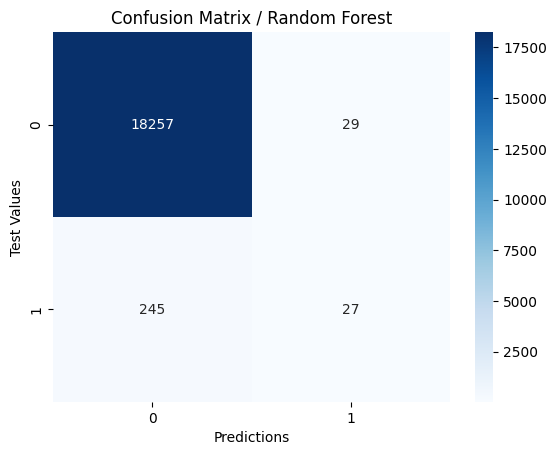

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

prediction = (y_pred_1 > 0.5).astype(int)

# Uncomment to view the model's Confusion Matrix

conf_matrix_features = confusion_matrix(y_test, prediction)

sns.heatmap(conf_matrix_features, annot = True, fmt = 'd', cmap='Blues')

plt.xlabel('Predictions')
plt.ylabel('Test Values')
plt.title('Confusion Matrix / Random Forest')
plt.savefig('conf_matrix_RandomForest.jpg')
plt.show()

In [156]:
from sklearn.svm import SVC

# instantiate classification model with given hyper parameters
clf = SVC(kernel='rbf', C=1.0)
clf.fit(X_train0, y_train0)

y_pred_2 = clf.predict(X_test0)

counter_p = len([valor for valor in y_pred_2 if valor > 0.5])
counter_r = len([valor_r for valor_r in y_test if valor_r > 0.5])
print('There are ',counter_p, ' labels (1) predicted')
print('There are ',counter_r, ' labels (1) in the reality')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


There are  0  labels (1) predicted
There are  272  labels (1) in the reality


In [157]:
from sklearn.ensemble import HistGradientBoostingClassifier

# iniciate classification model with given hyper parameters
clf = HistGradientBoostingClassifier() # n_estimators=10
clf.fit(X_train,y_train)

# prediction new data
y_pred_3 = clf.predict(X_test)

counter_p = len([valor for valor in y_pred_3 if valor > 0.5])
counter_r = len([valor_r for valor_r in y_test if valor_r > 0.5])
print('There are ',counter_p, ' labels (1) predicted')
print('There are ',counter_r, ' labels (1) in the reality')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


There are  29  labels (1) predicted
There are  272  labels (1) in the reality


In [158]:
from sklearn.metrics import average_precision_score

# Evaluation of performance

print('RandomForest PR-AUC = ',average_precision_score(y_test,y_pred_1))
print('SVC PR-AUC = ',average_precision_score(y_test,y_pred_2))
print('HistGradient PR-AUC = ',average_precision_score(y_test,y_pred_3))

RandomForest PR-AUC =  0.061061622555585435
SVC PR-AUC =  0.014656751805151417
HistGradient PR-AUC =  0.03538119457511312


In [159]:
print(dataX.shape)

(92790, 145)


In [160]:
import tensorflow as tf

# Function to improve the learning rate

def adapt_learning_rate(epoch):
    lr=0.001
    if epoch>100:
        lr=0.0001
    if epoch>200:
        lr=0.00005
    if epoch>240:
        lr=0.00001
    if epoch>700:
        lr=0.000005

    return lr

my_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate)


In [161]:
# Neural Network

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from keras.layers import Dropout

# Remplace the NaN values

constant_imputer = SimpleImputer(strategy='constant')
dataX_imp = constant_imputer.fit_transform(dataX)

# normalizacion 

scaler = MinMaxScaler(feature_range=(0, 1))
dataX_n = scaler.fit_transform(dataX_imp)

# split of data for training and test

training_input,input_temp,training_output,output_temp = train_test_split(dataX_n, dataY, test_size=0.3)
val_input,test_input,val_output,test_output = train_test_split(input_temp,output_temp,test_size=0.33)

# Network

model = Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(145,)))
model.add(Dense(100,activation='relu'))
model.add(Dense(200,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(250,activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(500,activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(250,activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(150,activation='relu'))
model.add(Dense(1,activation='sigmoid')) # Output

print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 100)               14600     
                                                                 
 dense_45 (Dense)            (None, 200)               20200     
                                                                 
 dropout_18 (Dropout)        (None, 200)               0         
                                                                 
 dense_46 (Dense)            (None, 250)               50250     
                                                                 
 dropout_19 (Dropout)        (None, 250)               0         
                                                                 
 dense_47 (Dense)            (None, 500)               125500    
                                                                 
 dropout_20 (Dropout)        (None, 500)             

In [162]:
# Define the metric average_precision as a personalised function
def average_precision(y_true, y_pred):
    return tf.py_function(average_precision_score, (y_true, y_pred), tf.float64)


In [163]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[average_precision])

In [164]:
model.fit(training_input,training_output,batch_size=800,epochs=50,
                    shuffle=True,callbacks=my_lr_scheduler,validation_data=(val_input,val_output))


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


82/82 [==============================] - 1s 13ms/step - loss: 0.1063 - average_precision: 0.0250 - val_loss: 0.0804 - val_average_precision: 0.0445 - lr: 0.0010
Epoch 2/50
 1/82 [..............................] - ETA: 0s - loss: 0.0699 - average_precision: 0.0184

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


82/82 [==============================] - 1s 12ms/step - loss: 0.0735 - average_precision: 0.0383 - val_loss: 0.0774 - val_average_precision: 0.0531 - lr: 0.0010
Epoch 3/50
82/82 [==============================] - 1s 13ms/step - loss: 0.0713 - average_precision: 0.0598 - val_loss: 0.0761 - val_average_precision: 0.0678 - lr: 0.0010
Epoch 4/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0699 - average_precision: 0.0771 - val_loss: 0.0767 - val_average_precision: 0.0640 - lr: 0.0010
Epoch 5/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0695 - average_precision: 0.0837 - val_loss: 0.0781 - val_average_precision: 0.0803 - lr: 0.0010
Epoch 6/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0687 - average_precision: 0.1000 - val_loss: 0.0757 - val_average_precision: 0.0944 - lr: 0.0010
Epoch 7/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0687 - average_precision: 0.0970 - val_loss: 0.0748 - val_average_precision:

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


82/82 [==============================] - 1s 12ms/step - loss: 0.0651 - average_precision: 0.1482 - val_loss: 0.0744 - val_average_precision: 0.1098 - lr: 0.0010
Epoch 15/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0648 - average_precision: 0.1434 - val_loss: 0.0738 - val_average_precision: 0.1120 - lr: 0.0010
Epoch 16/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0648 - average_precision: 0.1465 - val_loss: 0.0732 - val_average_precision: 0.1124 - lr: 0.0010
Epoch 17/50
 6/82 [=>............................] - ETA: 0s - loss: 0.0571 - average_precision: 0.1818

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


82/82 [==============================] - 1s 12ms/step - loss: 0.0652 - average_precision: 0.1439 - val_loss: 0.0741 - val_average_precision: 0.1096 - lr: 0.0010
Epoch 18/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0643 - average_precision: 0.1590 - val_loss: 0.0740 - val_average_precision: 0.1152 - lr: 0.0010
Epoch 19/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0642 - average_precision: 0.1629 - val_loss: 0.0752 - val_average_precision: 0.1151 - lr: 0.0010
Epoch 20/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0643 - average_precision: 0.1519 - val_loss: 0.0771 - val_average_precision: 0.1122 - lr: 0.0010
Epoch 21/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0641 - average_precision: 0.1540 - val_loss: 0.0739 - val_average_precision: 0.1115 - lr: 0.0010
Epoch 22/50
 6/82 [=>............................] - ETA: 0s - loss: 0.0684 - average_precision: 0.2098

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


82/82 [==============================] - 1s 13ms/step - loss: 0.0648 - average_precision: 0.1537 - val_loss: 0.0738 - val_average_precision: 0.1127 - lr: 0.0010
Epoch 23/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0640 - average_precision: 0.1564 - val_loss: 0.0781 - val_average_precision: 0.1105 - lr: 0.0010
Epoch 24/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0641 - average_precision: 0.1595 - val_loss: 0.0728 - val_average_precision: 0.1264 - lr: 0.0010
Epoch 25/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0628 - average_precision: 0.1650 - val_loss: 0.0720 - val_average_precision: 0.1248 - lr: 0.0010
Epoch 26/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0638 - average_precision: 0.1561 - val_loss: 0.0739 - val_average_precision: 0.1257 - lr: 0.0010
Epoch 27/50
82/82 [==============================] - 1s 12ms/step - loss: 0.0634 - average_precision: 0.1489 - val_loss: 0.0724 - val_average_preci

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


82/82 [==============================] - 1s 13ms/step - loss: 0.0615 - average_precision: 0.1857 - val_loss: 0.0746 - val_average_precision: 0.1306 - lr: 0.0010
Epoch 45/50
82/82 [==============================] - 1s 13ms/step - loss: 0.0619 - average_precision: 0.1776 - val_loss: 0.0729 - val_average_precision: 0.1309 - lr: 0.0010
Epoch 46/50
82/82 [==============================] - 1s 13ms/step - loss: 0.0616 - average_precision: 0.1906 - val_loss: 0.0734 - val_average_precision: 0.1270 - lr: 0.0010
Epoch 47/50
82/82 [==============================] - 1s 13ms/step - loss: 0.0611 - average_precision: 0.1832 - val_loss: 0.0734 - val_average_precision: 0.1312 - lr: 0.0010
Epoch 48/50
82/82 [==============================] - 1s 13ms/step - loss: 0.0618 - average_precision: 0.1879 - val_loss: 0.0752 - val_average_precision: 0.1207 - lr: 0.0010
Epoch 49/50
82/82 [==============================] - 1s 13ms/step - loss: 0.0616 - average_precision: 0.1727 - val_loss: 0.0753 - val_average_preci

In [165]:
# Validation of model performance with new data

y_pred_4 = model.predict(test_input)

counter_p = len([valor for valor in y_pred_4 if valor > 0.5])
counter_r = len([valor_r for valor_r in test_output if valor_r > 0.5])
print('There are ',counter_p, ' labels (1) predicted')
print('There are ',counter_r, ' labels (1) in the reality')

print('Neural Network without OverSampling PR-AUC = ',average_precision_score(test_output,y_pred_4))

288/288 [==============================] - 0s 733us/step
There are  5  labels (1) predicted
There are  132  labels (1) in the reality
Neural Network without OverSampling PR-AUC =  0.07015909141922626


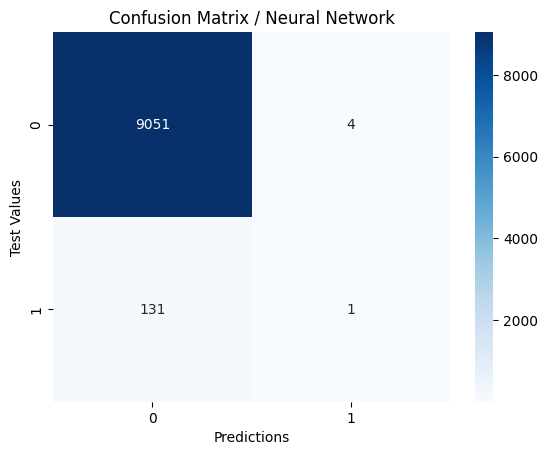

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

prediction = (y_pred_4 > 0.5).astype(int)

# Uncomment to view the model's Confusion Matrix

conf_matrix_features = confusion_matrix(test_output, prediction)

sns.heatmap(conf_matrix_features, annot = True, fmt = 'd', cmap='Blues')

plt.xlabel('Predictions')
plt.ylabel('Test Values')
plt.title('Confusion Matrix / Neural Network')
plt.savefig('conf_matrix_NeuralNetwork.jpg')
plt.show()

In [167]:
training_input_t,test_input,training_output_t,test_output = train_test_split(dataX_n, dataY, test_size=0.1)

# Oversampling with replication (duplicate of the minor instances)

df_train = pd.DataFrame(training_input_t,columns=df.columns)
datY_train = pd.DataFrame(training_output_t,columns=data_Y.columns)

minoritary_class_index = datY_train[datY_train['fraud_flag'] == 1].index

df_replic = pd.concat([df_train] + [df_train.iloc[minoritary_class_index]] * 33, ignore_index=True)

data_y_replic = pd.concat([datY_train] + [datY_train.iloc[minoritary_class_index]] * 33, ignore_index=True)

print('class distribution before replication')
print(datY_train['fraud_flag'].value_counts())
print('\n')
print('class distribution afeter replication')
print(data_y_replic['fraud_flag'].value_counts())

class distribution before replication
fraud_flag
0    82322
1     1189
Name: count, dtype: int64


class distribution afeter replication
fraud_flag
0    82322
1    40426
Name: count, dtype: int64


In [168]:
# Conversion to array

dataX_a = np.array(df_replic)
dataY_a = np.array(data_y_replic)

# Split in train and validation

training_input,val_input,training_output,val_output = train_test_split(dataX_a, dataY_a, test_size=0.222)

In [169]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[average_precision])

In [170]:
model.fit(training_input,training_output,batch_size=800,epochs=50,
                    shuffle=True,callbacks=my_lr_scheduler,validation_data=(val_input,val_output))

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


120/120 [==============================] - 2s 14ms/step - loss: 0.4873 - average_precision: 0.6939 - val_loss: 0.4566 - val_average_precision: 0.7276 - lr: 0.0010
Epoch 2/50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


120/120 [==============================] - 2s 13ms/step - loss: 0.4506 - average_precision: 0.7189 - val_loss: 0.4435 - val_average_precision: 0.7419 - lr: 0.0010
Epoch 3/50
120/120 [==============================] - 2s 13ms/step - loss: 0.4415 - average_precision: 0.7288 - val_loss: 0.4341 - val_average_precision: 0.7488 - lr: 0.0010
Epoch 4/50
120/120 [==============================] - 2s 19ms/step - loss: 0.4392 - average_precision: 0.7326 - val_loss: 0.4341 - val_average_precision: 0.7523 - lr: 0.0010
Epoch 5/50
120/120 [==============================] - 2s 14ms/step - loss: 0.4315 - average_precision: 0.7401 - val_loss: 0.4251 - val_average_precision: 0.7588 - lr: 0.0010
Epoch 6/50
120/120 [==============================] - 2s 14ms/step - loss: 0.4285 - average_precision: 0.7432 - val_loss: 0.4220 - val_average_precision: 0.7643 - lr: 0.0010
Epoch 7/50
120/120 [==============================] - 2s 14ms/step - loss: 0.4263 - average_precision: 0.7448 - val_loss: 0.4229 - val_averag

In [171]:
# Validation of model performance with new data

y_pred_5 = model.predict(test_input)

counter_p = len([valor for valor in y_pred_5 if valor > 0.5])
counter_r = len([valor_r for valor_r in test_output if valor_r > 0.5])
print('There are ',counter_p, ' labels (1) predicted')
print('There are ',counter_r, ' labels (1) in the reality')

print('Neural Network Oversampling Replication PR-AUC = ',average_precision_score(test_output,y_pred_5))

290/290 [==============================] - 0s 757us/step
There are  967  labels (1) predicted
There are  130  labels (1) in the reality
Neural Network Oversampling Replication PR-AUC =  0.09801389567306908


In [172]:
# SMOTE tecnique (Syntetic geenration of data)

from imblearn.over_sampling import SMOTE

# Return to dataframe

# df_train = pd.DataFrame(training_input_t,columns=df.columns)
# datY_train = pd.DataFrame(training_output_t,columns=data_Y.columns)

# Aplication of SMOTE

count_minoritary_class = len(datY_train[datY_train['fraud_flag'] == 1])
smote = SMOTE(sampling_strategy={1:(34*count_minoritary_class)}, random_state=42) # the {1:4} means have the class with label 1, 4 times, so increase 3 values

df_smote,data_y_smote = smote.fit_resample(df_train,datY_train)

# Print number each class
print('class distribution before SMOTE')
print(datY_train['fraud_flag'].value_counts())
print('\n')
print('class distribution after SMOTE')
print(data_y_smote['fraud_flag'].value_counts())

print(df_train.shape)
print(df_smote.shape)
# Conversion to array

dataX_a = np.array(df_smote)
dataY_a = np.array(data_y_smote)

# Split in train and validation

training_input,val_input,training_output,val_output = train_test_split(dataX_a, dataY_a, test_size=0.222)


class distribution before SMOTE
fraud_flag
0    82322
1     1189
Name: count, dtype: int64


class distribution after SMOTE
fraud_flag
0    82322
1    40426
Name: count, dtype: int64
(83511, 145)
(122748, 145)


In [173]:
# SMOTE tecnique (Syntetic geenration of data)

from imblearn.over_sampling import SMOTE

# Return to dataframe

# df_train = pd.DataFrame(training_input_t,columns=df.columns)
# datY_train = pd.DataFrame(training_output_t,columns=data_Y.columns)


training_input_extraT,val_input_extra,training_output_extraT,val_output_extra = train_test_split(df_train, datY_train, test_size=0.222)



# Aplication of SMOTE

count_minoritary_class = len(training_output_extraT[training_output_extraT['fraud_flag'] == 1])
smote = SMOTE(sampling_strategy={1:(34*count_minoritary_class)}, random_state=42) # the {1:4} means have the class with label 1, 4 times, so increase 3 values

df_smote,data_y_smote = smote.fit_resample(training_input_extraT,training_output_extraT)

# Print number each class
print('class distribution before SMOTE')
print(training_output_extraT['fraud_flag'].value_counts())
print('\n')
print('class distribution after SMOTE')
print(data_y_smote['fraud_flag'].value_counts())


# Conversion to array

dataX_a = np.array(df_smote)
dataY_a = np.array(data_y_smote)

# Split in train and validation
training_input_extra,training_output_extra = dataX_a,dataY_a

class distribution before SMOTE
fraud_flag
0    64038
1      933
Name: count, dtype: int64


class distribution after SMOTE
fraud_flag
0    64038
1    31722
Name: count, dtype: int64


In [174]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[average_precision])

In [175]:
history = model.fit(training_input,training_output,batch_size=800,epochs=250,
                    shuffle=True,callbacks=my_lr_scheduler,validation_data=(val_input,val_output))

Epoch 1/250


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


120/120 [==============================] - ETA: 0s - loss: 0.3931 - average_precision: 0.7831

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


120/120 [==============================] - 2s 14ms/step - loss: 0.3931 - average_precision: 0.7831 - val_loss: 0.3801 - val_average_precision: 0.7888 - lr: 0.0010
Epoch 2/250
120/120 [==============================] - 2s 14ms/step - loss: 0.3877 - average_precision: 0.7888 - val_loss: 0.3780 - val_average_precision: 0.7869 - lr: 0.0010
Epoch 3/250
120/120 [==============================] - 2s 14ms/step - loss: 0.3774 - average_precision: 0.7960 - val_loss: 0.3832 - val_average_precision: 0.7824 - lr: 0.0010
Epoch 4/250
120/120 [==============================] - 2s 14ms/step - loss: 0.3790 - average_precision: 0.7947 - val_loss: 0.3760 - val_average_precision: 0.7917 - lr: 0.0010
Epoch 5/250
120/120 [==============================] - 2s 14ms/step - loss: 0.3766 - average_precision: 0.7964 - val_loss: 0.4031 - val_average_precision: 0.7745 - lr: 0.0010
Epoch 6/250
120/120 [==============================] - 2s 14ms/step - loss: 0.3764 - average_precision: 0.7973 - val_loss: 0.3703 - val_a

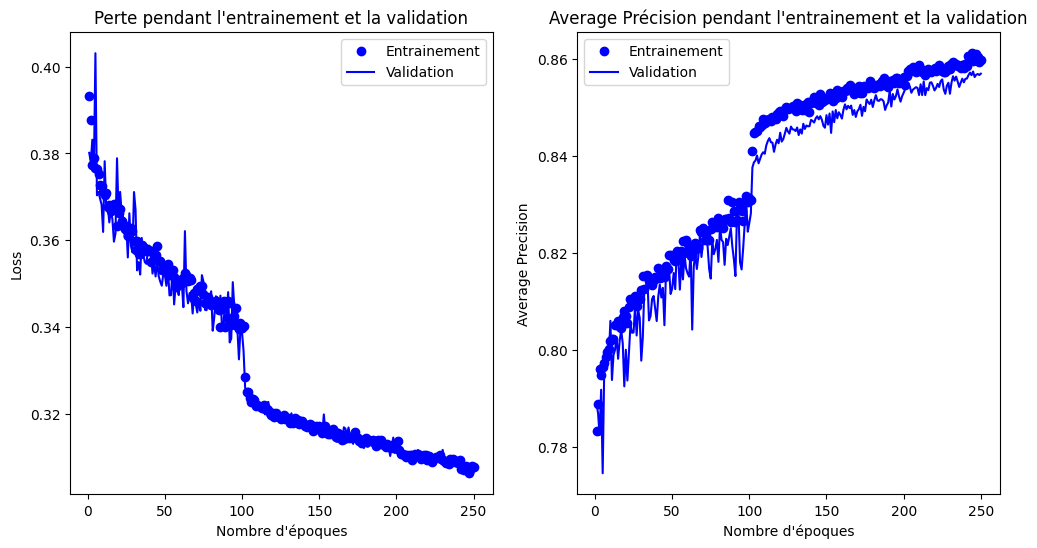

In [176]:
# Visualization of the model

import matplotlib.pyplot as plt

# plot fonction perte

loss=history.history['loss']

val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.figure(figsize=(12,6))


plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label = 'Entrainement')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Perte pendant l\'entrainement et la validation')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Loss')
plt.legend()

# plot precision du model

avp = history.history['average_precision']
val_avp = history.history['val_average_precision']

plt.subplot(1,2,2)
plt.plot(epochs,avp,'bo',label='Entrainement')
plt.plot(epochs, val_avp, 'b', label='Validation')
plt.title('Average Précision pendant l\'entrainement et la validation')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Average Precision')
plt.legend()
plt.savefig('loss_accuracy_model_valSMOTE.jpg')
plt.show()

In [177]:
history_2=model.fit(training_input_extra,training_output_extra,batch_size=800,epochs=250,
                    shuffle=True,callbacks=my_lr_scheduler,validation_data=(val_input_extra,val_output_extra))

Epoch 1/250
120/120 [==============================] - 2s 17ms/step - loss: 0.3510 - average_precision: 0.8235 - val_loss: 0.2697 - val_average_precision: 0.2410 - lr: 0.0010
Epoch 2/250
  1/120 [..............................] - ETA: 1s - loss: 0.3179 - average_precision: 0.8607

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


120/120 [==============================] - 2s 16ms/step - loss: 0.3424 - average_precision: 0.8306 - val_loss: 0.2598 - val_average_precision: 0.2320 - lr: 0.0010
Epoch 3/250
120/120 [==============================] - 2s 17ms/step - loss: 0.3382 - average_precision: 0.8346 - val_loss: 0.2614 - val_average_precision: 0.2286 - lr: 0.0010
Epoch 4/250
120/120 [==============================] - 2s 16ms/step - loss: 0.3366 - average_precision: 0.8360 - val_loss: 0.2651 - val_average_precision: 0.2422 - lr: 0.0010
Epoch 5/250
120/120 [==============================] - 2s 16ms/step - loss: 0.3343 - average_precision: 0.8382 - val_loss: 0.2190 - val_average_precision: 0.2077 - lr: 0.0010
Epoch 6/250
120/120 [==============================] - 2s 16ms/step - loss: 0.3349 - average_precision: 0.8371 - val_loss: 0.2823 - val_average_precision: 0.2345 - lr: 0.0010
Epoch 7/250
120/120 [==============================] - 2s 16ms/step - loss: 0.3329 - average_precision: 0.8392 - val_loss: 0.2430 - val_a

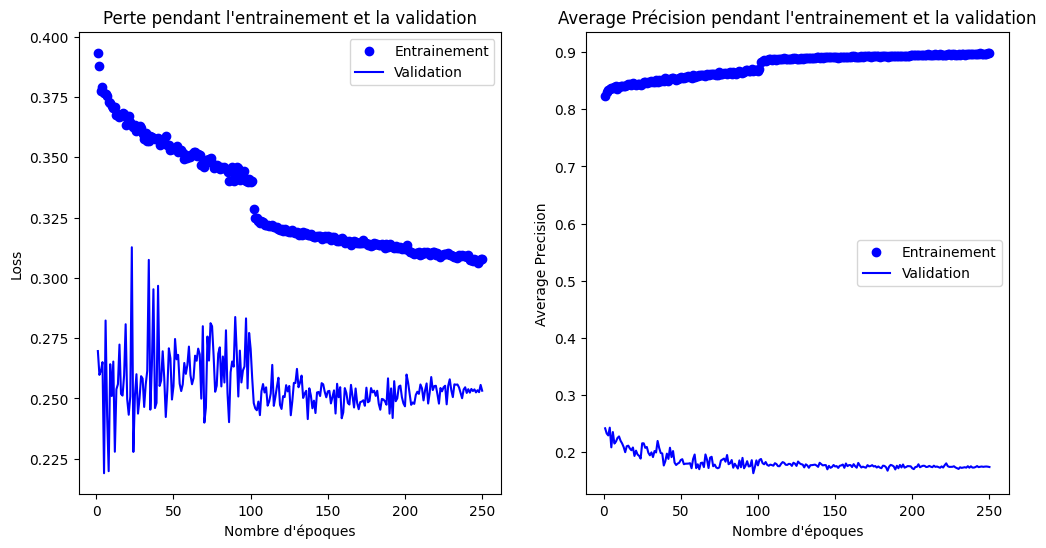

In [178]:
# Visualization of the model

import matplotlib.pyplot as plt

# plot fonction perte

loss=history.history['loss']

val_loss = history_2.history['val_loss']
epochs = range(1,len(loss)+1)

plt.figure(figsize=(12,6))


plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label = 'Entrainement')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Perte pendant l\'entrainement et la validation')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Loss')
plt.legend()

# plot precision du model

avp = history_2.history['average_precision']
val_avp = history_2.history['val_average_precision']

plt.subplot(1,2,2)
plt.plot(epochs,avp,'bo',label='Entrainement')
plt.plot(epochs, val_avp, 'b', label='Validation')
plt.title('Average Précision pendant l\'entrainement et la validation')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Average Precision')
plt.legend()
plt.savefig('loss_accuracy_model_valnormal.jpg')
plt.show()

In [179]:
# Validation of model performance with new data

y_pred_5 = model.predict(test_input)

counter_p = len([valor for valor in y_pred_5 if valor > 0.5])
counter_r = len([valor_r for valor_r in test_output if valor_r > 0.5])
print('There are ',counter_p, ' labels (1) predicted')
print('There are ',counter_r, ' labels (1) in the reality')

print('Neural Network oversampling SMOTE PR-AUC = ',average_precision_score(test_output,y_pred_5))

290/290 [==============================] - 0s 754us/step
There are  887  labels (1) predicted
There are  130  labels (1) in the reality
Neural Network oversampling SMOTE PR-AUC =  0.11065360869967453


In [180]:
# Network 2 Less layers

model_1 = Sequential()

model_1.add(tf.keras.layers.InputLayer(input_shape=(145,)))
model_1.add(Dense(100,activation='relu'))
model_1.add(Dense(200,activation='tanh'))
model_1.add(Dropout(0.4))
model_1.add(Dense(250,activation='selu'))
model_1.add(Dense(1,activation='sigmoid')) # Output

print(model_1.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 100)               14600     
                                                                 
 dense_52 (Dense)            (None, 200)               20200     
                                                                 
 dropout_22 (Dropout)        (None, 200)               0         
                                                                 
 dense_53 (Dense)            (None, 250)               50250     
                                                                 
 dense_54 (Dense)            (None, 1)                 251       
                                                                 
Total params: 85301 (333.21 KB)
Trainable params: 85301 (333.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [181]:
model_1.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[average_precision])

In [182]:
history_1=model_1.fit(training_input,training_output,batch_size=800,epochs=50,
                    shuffle=True,callbacks=my_lr_scheduler,validation_data=(val_input,val_output))

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


120/120 [==============================] - 1s 5ms/step - loss: 0.5868 - average_precision: 0.4917 - val_loss: 0.5421 - val_average_precision: 0.5745 - lr: 0.0010
Epoch 2/50
 15/120 [==>...........................] - ETA: 0s - loss: 0.5488 - average_precision: 0.5684

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


120/120 [==============================] - 1s 5ms/step - loss: 0.5296 - average_precision: 0.6099 - val_loss: 0.5104 - val_average_precision: 0.6302 - lr: 0.0010
Epoch 3/50
120/120 [==============================] - 1s 7ms/step - loss: 0.4994 - average_precision: 0.6621 - val_loss: 0.4866 - val_average_precision: 0.6752 - lr: 0.0010
Epoch 4/50
120/120 [==============================] - 1s 6ms/step - loss: 0.4761 - average_precision: 0.6896 - val_loss: 0.4793 - val_average_precision: 0.6724 - lr: 0.0010
Epoch 5/50
120/120 [==============================] - 1s 6ms/step - loss: 0.4649 - average_precision: 0.7009 - val_loss: 0.4575 - val_average_precision: 0.7033 - lr: 0.0010
Epoch 6/50
120/120 [==============================] - 1s 5ms/step - loss: 0.4557 - average_precision: 0.7124 - val_loss: 0.4522 - val_average_precision: 0.7080 - lr: 0.0010
Epoch 7/50
120/120 [==============================] - 1s 5ms/step - loss: 0.4523 - average_precision: 0.7186 - val_loss: 0.4423 - val_average_prec

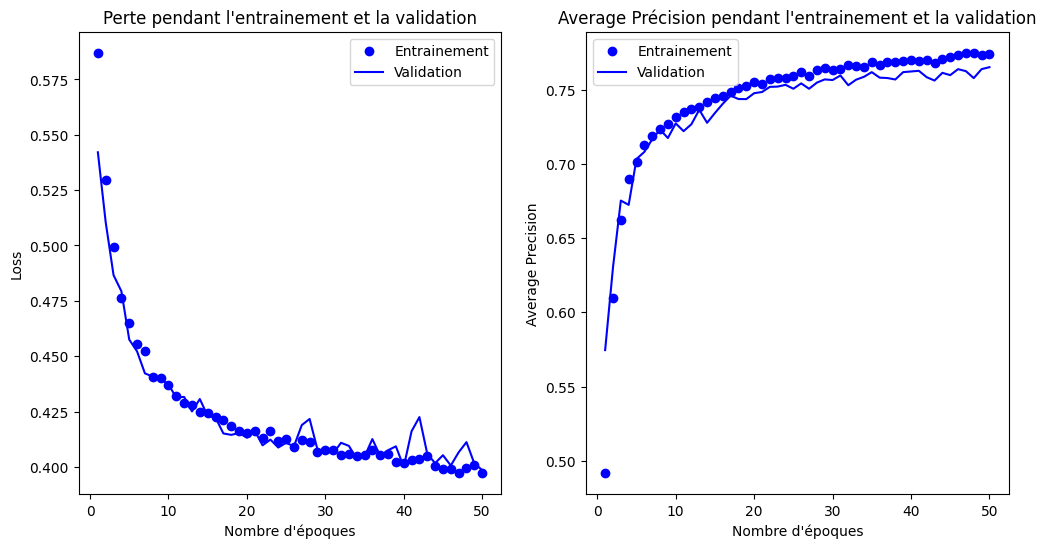

In [183]:
# Visualization of the model

import matplotlib.pyplot as plt

# plot fonction perte

loss=history_1.history['loss']

val_loss = history_1.history['val_loss']
epochs = range(1,len(loss)+1)

plt.figure(figsize=(12,6))


plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label = 'Entrainement')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Perte pendant l\'entrainement et la validation')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Loss')
plt.legend()

# plot precision du model

avp = history_1.history['average_precision']
val_avp = history_1.history['val_average_precision']

plt.subplot(1,2,2)
plt.plot(epochs,avp,'bo',label='Entrainement')
plt.plot(epochs, val_avp, 'b', label='Validation')
plt.title('Average Précision pendant l\'entrainement et la validation')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Average Precision')
plt.legend()
plt.savefig('loss_accuracy_model.jpg')
plt.show()

In [184]:
# Validation of model performance with new data

y_pred_6 = model_1.predict(test_input)

counter_p = len([valor for valor in y_pred_6 if valor > 0.5])
counter_r = len([valor_r for valor_r in test_output if valor_r > 0.5])
print('There are ',counter_p, ' labels (1) predicted')
print('There are ',counter_r, ' labels (1) in the reality')

print('Neural Network oversampling SMOTE PR-AUC = ',average_precision_score(test_output,y_pred_6))

290/290 [==============================] - 0s 506us/step
There are  1334  labels (1) predicted
There are  130  labels (1) in the reality
Neural Network oversampling SMOTE PR-AUC =  0.08148338493569322


In [185]:
df_train,datY_train


(          item1     item2  item3  item4  item5  item6  item7  item8  item9  \
 0      0.000000  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 1      0.015038  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 2      0.000000  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 3      0.000000  0.913333    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 4      0.015038  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 ...         ...       ...    ...    ...    ...    ...    ...    ...    ...   
 83506  0.000000  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 83507  0.000000  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 83508  0.000000  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 83509  0.007519  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 83510  0.000000  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
 
        item10  ...  Nbr_of_prod_purchas16  Nbr_of